## **【問題1】クロスバリデーション**

In [2]:
import pandas as pd

print("")
print("pd.read_csv()を使用して、変数に格納")
print("")
application_train = pd.read_csv('application_train.csv')


pd.read_csv()を使用して、変数に格納



In [3]:
# 列抽出　特徴量　DAYS_BIRTH, DAYS_EMPLOYED
df_selected = application_train.query("TARGET in [0, 1]").loc[:, ["DAYS_BIRTH", "DAYS_EMPLOYED", "TARGET"]]

# absで絶対値、日数/３６５で年に換算
series_selected_0 = abs(df_selected.iloc[:,0]/365)
series_selected_1 = abs(df_selected.iloc[:,1]/365)
series_selected_2 = df_selected.iloc[:,2]
# 列結合
df_selected = pd.concat([series_selected_0, series_selected_1, series_selected_2],axis=1)

# DataFrameをndarrayへ変換
df_selected_array = df_selected.values
# 特徴量（説明変数）をX_ndarray、正解（目的変数）をy_ndarrayというndarrayに格納
X_array = df_selected_array[ : , 0:2] # (307511, 2)
y_array = df_selected_array[ : , 2] # y_array.shape (307511,)

In [4]:
# KFold（K-分割交差検証）
import numpy as np
from sklearn.model_selection import KFold

#KFoldのインスタンスを作成
kf = KFold(n_splits=5, random_state=None, shuffle=False)
# 分割
for train_index, test_index in kf.split(X_array):
    print("train_index:", train_index)
    print("test_index:", test_index)
    print()  # 1行開ける
    
    X_train, X_test = X_array[train_index], X_array[test_index]
    # X_train.shape (246009, 2) X_test.shape (61502, 2)
    # 61502 /2 46009 = 0.2499989837770163
    y_train, y_test = y_array[train_index], y_array[test_index]
    # y_train.shape (246009,) y_test.shape (61502,)

train_index: [ 61503  61504  61505 ... 307508 307509 307510]
test_index: [    0     1     2 ... 61500 61501 61502]

train_index: [     0      1      2 ... 307508 307509 307510]
test_index: [ 61503  61504  61505 ... 123002 123003 123004]

train_index: [     0      1      2 ... 307508 307509 307510]
test_index: [123005 123006 123007 ... 184504 184505 184506]

train_index: [     0      1      2 ... 307508 307509 307510]
test_index: [184507 184508 184509 ... 246006 246007 246008]

train_index: [     0      1      2 ... 246006 246007 246008]
test_index: [246009 246010 246011 ... 307508 307509 307510]



## **【問題2】グリッドサーチ**

そして、ベースラインモデルに対して何らかしらのパラメータチューニングを行なってください。
どのパラメータをチューニングするかは、使用した手法の公式ドキュメントを参考にしてください。

GridSearchCVクラスには引数としてモデル、探索範囲、さらにクロスバリデーションを何分割で行うかを与えます。
クロスバリデーションの機能も含まれているため、これを使用する場合はKFoldクラスを利用する必要はありません。

In [6]:
from sklearn import datasets
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import tree
import pandas as pd

# 列抽出　特徴量　DAYS_BIRTH, DAYS_EMPLOYED
df_selected = application_train.query("TARGET in [0, 1]").loc[:, ["DAYS_BIRTH", "DAYS_EMPLOYED", "TARGET"]]


# absで絶対値、日数/３６５で年に換算
series_selected_0 = abs(df_selected.iloc[:,0]/365)
series_selected_1 = abs(df_selected.iloc[:,1]/365)
series_selected_2 = df_selected.iloc[:,2]
# 列結合
df_selected = pd.concat([series_selected_0, series_selected_1, series_selected_2],axis=1)


# DataFrameをndarrayへ変換
df_selected_array = df_selected.values
# 特徴量（説明変数）をX_ndarray、正解（目的変数）をy_ndarrayというndarrayに格納
X_ndarray = df_selected_array[ : , 0:2]
y_ndarray = df_selected_array[ : , 2]
 
train_X, test_X, train_Y, test_Y = train_test_split(X_ndarray, y_ndarray, # 訓練データとテストデータに分割する
                                                    test_size=0.25,       # テストデータの割合
                                                     random_state=42)      # 乱数シードを固定する
 
# グリッドサーチ用のパラメータを辞書型で設定
param = {'max_depth':[1, 2, 3, 4, 5],
         'min_samples_leaf':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
         'min_samples_split':[2, 3, 4, 5]}
 
# 決定木による学習
clf = GridSearchCV(tree.DecisionTreeClassifier(),   # グリッドサーチで決定木を定義
                   param, cv=5)
clf.fit(train_X, train_Y)                           # フィッティング

print(clf.best_score_)  # 最も良かったスコア
print(clf.best_params_)  # 上記を記録したパラメータの組み合わせ
   

# スコアとパラメータの組み合わせ
# scores = clf.cv_results_['mean_test_score']
# params = clf.cv_results_['params']
 
# # 結果の確認
# best_clf = clf.best_estimator_
# print('最良条件:\n', best_clf)
# print('訓練スコア:\n', best_clf.score(train_X, train_Y))
# print('テストスコア:\n', best_clf.score(test_X, test_Y))
# for i in range(len(scores)):
#     print(scores[i], params[i])

0.9192049707149706
{'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}


## **【問題3】Kaggle Notebooksからの調査**

K-Foldクロスバリデーションを用いて、オーバーフィッティングを回避している。
明らかにデータセットが不均衡であることがわかる。最終的なモデル化のためのアプローチとして、層別Kフォールドクロスバリデーションを用いることで、より良い方法でデフォルトローンを識別できるモデルになることが期待される。
上記の roc_auc_score は、良いテストセットがたまたま選択されたことによるものと思われる。上記のroc_auc_scoreは、たまたま良いテストセットが選択されたためと考えられる。

## **【問題4】高い汎化性能のモデル作成**

In [7]:
df = application_train[0:10000]

In [8]:
y = df['TARGET'].copy()
x = df[['CODE_GENDER', 'NAME_FAMILY_STATUS', 'AMT_CREDIT', 'DAYS_BIRTH']].copy()
df_test = df[['TARGET', 'CODE_GENDER', 'NAME_FAMILY_STATUS', 'AMT_CREDIT',
              'DAYS_BIRTH']].copy()

In [9]:
x['CODE_GENDER'] 
x['CODE_GENDER'] = x['CODE_GENDER'].map({'M' : 0, 'F' : 1}).astype(int) # 性別のダミー変数

In [10]:
x['NAME_FAMILY_STATUS'] = x['NAME_FAMILY_STATUS'].map({'Civil marriage' : 0,
                'Married' : 1, 'Separated' : 2, 'Single / not married' : 3,
                'Widow' : 4}).astype(int) # 性別のダミー変数

In [11]:
from sklearn.model_selection import train_test_split
x_train, x_test = train_test_split(x.values, random_state=0).copy()
y_train, y_true = train_test_split(y.values, random_state=0).copy()

In [12]:
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as me
from sklearn.metrics import classification_report

logi = LogisticRegression()
logi.fit(x_train, y_train)
logi_pred = logi.predict(x_test)
logi_confusion = me.confusion_matrix(y_true, logi_pred) 
print(logi_confusion) # 混同行列
print(classification_report(y_true, logi_pred))

[[2306    0]
 [ 194    0]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2306
           1       0.00      0.00      0.00       194

    accuracy                           0.92      2500
   macro avg       0.46      0.50      0.48      2500
weighted avg       0.85      0.92      0.89      2500



/Users/shunnadamoto/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shunnadamoto/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shunnadamoto/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

,th_all,tpr_all,fpr_all
0,1.232335,0.000000,0.000000
1,0.232335,0.000000,0.000434
2,0.230754,0.000000,0.001301
3,0.229561,0.005155,0.001301
4,0.210383,0.005155,0.012142
...,...,...,...
353,0.023893,0.989691,0.969644
354,0.017928,0.989691,0.996964
355,0.017884,0.994845,0.996964
356,0.014933,0.994845,1.000000


AUC : 0.6148863118176697


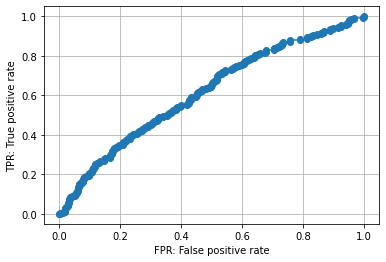

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
# predict_probaは、それぞれのターゲットが予測されたクラスに属する確率を0～1の実数で表す。
# fpr, tpr, thresholdsで、それぞれFPR（偽陽性率）、TPR（真陽性率）、閾値。
fpr_all, tpr_all, th_all  = me.roc_curve(y_true, logi.predict_proba(x_test)[:, 1], pos_label=1)# 正解ラベル１を1に設定、なのでみるべきなのは0を取る時の確率密度
df_roc = pd.DataFrame({'th_all': th_all, 'tpr_all': tpr_all, 'fpr_all': fpr_all}) # 閾値、再現率(recall)、陰性を間違えて陽性と判断した場合
# fprを横軸、tprを縦軸にプロットしたものをROC曲線
plt.plot(fpr_all, tpr_all, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
display(df_roc)
print('AUC : {}'.format(roc_auc_score(y_true, logi.predict_proba(x_test)[:, 1])))

In [14]:
application_test = pd.read_csv('application_test.csv')

In [15]:
# データの読み込み
x_testdata = application_test[['CODE_GENDER', 'NAME_FAMILY_STATUS',
                'AMT_CREDIT', 'DAYS_BIRTH', 'DAYS_REGISTRATION']].copy() 

In [16]:
x_testdata['CODE_GENDER'] = x_testdata['CODE_GENDER'].map({'M' : 0, 'F' : 1, 'XNA' : 2}).astype(int) # 性別のダミー変数
x_testdata['NAME_FAMILY_STATUS'] = x_testdata['NAME_FAMILY_STATUS'].map({'Civil marriage' : 0, 'Married' : 1, 'Separated' : 2, 'Single / not married' : 3,
                                                                         'Widow' : 4, 'Unknown' : 5}).astype(int) # 性別のダミー変数

In [17]:
# logi_pred_testdata = logi.predict(x_testdata.values) # 結果の出力

In [50]:
df_test = application_test
sk_id = df_test['SK_ID_CURR']

In [51]:
x = df_test[['CODE_GENDER', 'NAME_FAMILY_STATUS', 'AMT_CREDIT', 'DAYS_BIRTH']].copy()

In [52]:
x['CODE_GENDER'] 
x['CODE_GENDER'] = x['CODE_GENDER'].map({'M' : 0, 'F' : 1}).astype(int) # 性別のダミー変数

In [53]:
x['NAME_FAMILY_STATUS'] = x['NAME_FAMILY_STATUS'].map({'Civil marriage' : 0,
                'Married' : 1, 'Separated' : 2, 'Single / not married' : 3,
                'Widow' : 4}).astype(int) # 性別のダミー変数

In [54]:
logi_pred_testdata = logi.predict(x.values) # 結果の出力

In [55]:
type(logi_pred_testdata)

numpy.ndarray

In [56]:
homecredit_submission = pd.DataFrame({ 'SK_ID_CURR': sk_id,'TARGET': logi_pred_testdata})
# homecredit_submission.to_csv("drive/My Drive/Sprint1/homecredit_submission.csv", index=False)

In [60]:
homecredit_submission.to_csv("homecredit_submission.csv", index = False)

In [58]:
logi_pred_testdata

array([0, 0, 0, ..., 0, 0, 0])

In [59]:
homecredit_submission

,SK_ID_CURR,TARGET
0,100001,0
1,100005,0
2,100013,0
3,100028,0
4,100038,0
...,...,...
48739,456221,0
48740,456222,0
48741,456223,0
48742,456224,0


## **【問題5】最終的なモデルの選定**

homecredit_submission.csv
a minute ago
1 seconds
1 seconds
0.50000

kaggleから参考コードを持ってきてトライしたがスコアが出ず。特徴量の選択によりAUCスコアが良くなっているように思えた。